In [ ]:
# default_exp examples.protocols

# Example protocols

> Collection of protocols used for show-casing examples of samplings.

In [ ]:
# hide
from nbdev.showdoc import *

In [ ]:
# export
from qsam.examples.circuits import *
from qsam.datatypes.protocol import Protocol
from qsam.datatypes.circuit import Circuit

import numpy as np

## GHZ repeat until success protocol
* Repeat GHZ preparation circuit for a maximum of 3 times.
* Only repeat if a measurement yields `1`, i.e. the flag has been triggered.
* If we measure in all 3 runs three times `1`, count a logical failure.
* In all other cases the protocol completed without logical failure.

In [ ]:
# export

def gen_ghz3():
    
    def repeat(m):
        return len(m) < 3 and m[-1] == 1

    def logErr(m):
        return len(m) >= 3 and m == [1,1,1]

    functions = {'logErr': logErr, 'repeat': repeat}

    ghz3 = Protocol()
    ghz3._check_fns.update(functions)
    ghz3.add_nodes_from(['ghz'], circuits=[ghz])

    ghz3.add_edge('START', 'ghz', check='True')

    ghz3.add_edge('ghz', 'ghz', check='repeat(ghz)')
    ghz3.add_edge('ghz', 'FAIL', check='logErr(ghz)')
    
    ghz3.fault_tolerant = True
    
    return ghz3
ghz3 = gen_ghz3()

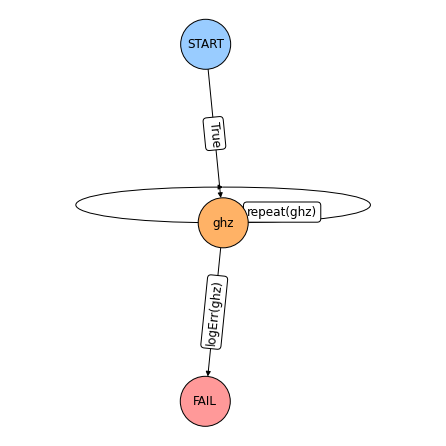

In [ ]:
ghz3.draw(figsize=(6,6))

## GHZ stabilizer measurement
* Prepare GHZ state with flag measurement `0`. (If `1` is measured repeat preparation as often as necessary)
* Reset ancilla and measure the stabilizers of the GHZ state (without noise). The stabilizers are:
    * One XXXX stab
    * and three ZZ stabs
* Use syndrom from stabilizer measurements to lookup and perform the correction.
* Measure stabilizers again.
* Now we have a logical failure if this measurement gives us any syndrome, i.e. if the measurement is anything other than four `0`s.

In [ ]:
# export

def gen_ghz_stab():
    def logErr(m):
        return m != 0b0000

    def lut(s):
        syn = format(s, '04b')
        sx = syn[0]
        sz = syn[1:]
        #print(sx, sz)

        c = Circuit(noisy=False)

        if sx == '1':
            c.insert(tick_index=0, tick={'Z': {0}})

        if sz in ['001', '100', '110', '011']: #, '101']: # '111' and '010' can only guess, '000' trivial
            corrs = {'001': {3}, '100': {0}, '110': {1}, '011': {2}} #, '101': {0,3}}
            c.insert(tick_index=0, tick={'X': corrs[sz]})

        return c

    functions = {'logErr': logErr, 'lut': lut}

    ghz_stab = Protocol()
    ghz_stab._check_fns.update(functions)
    ghz_stab.add_nodes_from(['ghz', 'meas_1', 'meas_2'], circuits=[ghz, ghz_stabs, ghz_stabs])

    ghz_stab.add_node('COR', circuit=Circuit(noisy=False))
    ghz_stab.add_edge('START', 'ghz', check='True')
    ghz_stab.add_edge('ghz', 'ghz', check='ghz[-1]==1')
    ghz_stab.add_edge('ghz', 'meas_1', check='ghz[-1]==0')
    ghz_stab.add_edge('meas_1', 'COR', check='lut(meas_1[-1])')
    ghz_stab.add_edge('COR', 'meas_2', check='True')
    ghz_stab.add_edge('meas_2', 'FAIL', check='logErr(meas_2[-1])')
    
    ghz_stab.fault_tolerant = True
    
    return ghz_stab
ghz_stab = gen_ghz_stab()

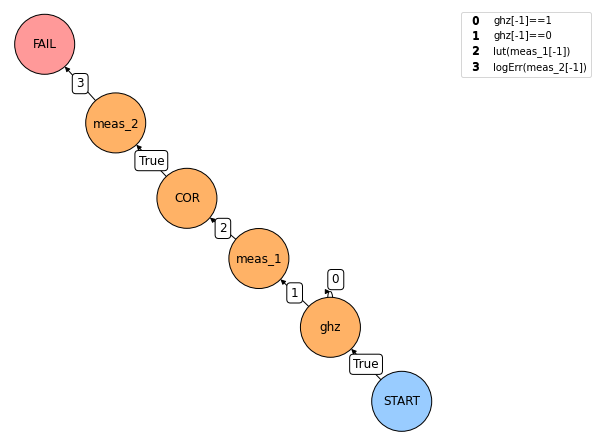

In [ ]:
ghz_stab.draw(figsize=(6,6), edge_legend=True)

## Fault-tolerant color code flag protocol
* ...

In [ ]:
# export

def gen_ftsteane():
    k1 = 0b0001111
    k2 = 0b1010101
    k3 = 0b0110011
    k12 = k1 ^ k2
    k23 = k2 ^ k3
    k13 = k1 ^ k3
    k123 = k12 ^ k3
    stabilizerGenerators = [k1, k2, k3]
    stabilizerSet = [0, k1, k2, k3, k12, k23, k13, k123]

    def hamming2(x, y):
        count, z = 0, x ^ y
        while z:
            count += 1
            z &= z - 1
        return count

    def logErr(out):

        if min([hamming2(out, i) for i in stabilizerSet]) > 1:
            return True
        else:
            return False

    functions = {"logErr": logErr}

    # Define protocol

    ftsteane = Protocol()
    ftsteane._check_fns.update(functions)
    ftsteane.add_nodes_from(['ENC', 'meas'], circuits=[eft, meas7])

    ftsteane.add_edge('START', 'ENC', check='True')

    ftsteane.add_edge('ENC', 'ENC', check='ENC[-1]==1')
    ftsteane.add_edge('ENC', 'meas', check='ENC[-1]==0')

    ftsteane.add_edge('meas', 'FAIL', check='logErr(meas[-1])')
    
    ftsteane.fault_tolerant = True
    
    return ftsteane
ftsteane = gen_ftsteane()

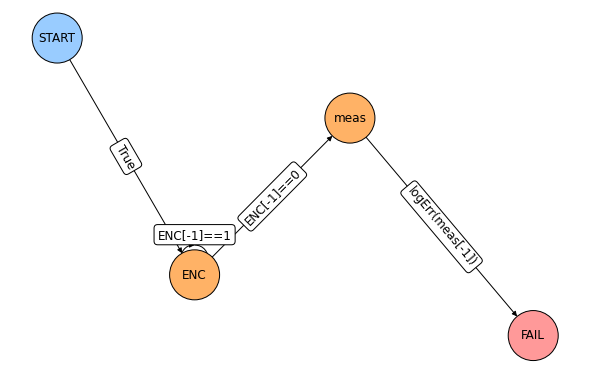

In [ ]:
ftsteane.draw(figsize=(8,5), self_loop_offset=(0,0.2))

## Det. Steane logical 0 preparation protocol

In [ ]:
#export

def gen_steane0():
    k1 = 0b0001111
    k2 = 0b1010101
    k3 = 0b0110011
    k12 = k1 ^ k2
    k23 = k2 ^ k3
    k13 = k1 ^ k3
    k123 = k12 ^ k3
    stabilizerGenerators = [k1, k2, k3]
    stabilizerSet = [0, k1, k2, k3, k12, k23, k13, k123]

    def hamming2(x, y):
        count, z = 0, x ^ y
        while z:
            count += 1
            z &= z - 1
        return count


    def logErr(out):
        c = np.array([hamming2(out, i) for i in stabilizerSet])
        d = np.flatnonzero(c <= 1)
        e = np.array([hamming2(out ^ (0b1111111), i) for i in stabilizerSet])
        f = np.flatnonzero(e <= 1)
        if len(d) != 0:
            return False
        elif len(f) != 0:
            return True
        if len(d) != 0 and len(f) != 0: 
            raise('-!-!-CANNOT BE TRUE-!-!-')

    def flagged_z_look_up_table_1(z):
        s = [z]

        if s == [1]:
            return True
        else: 
            return False

    functions = {"logErr": logErr, "lut": flagged_z_look_up_table_1}

    init = Protocol()
    init._check_fns.update(functions)
    init.add_nodes_from(['ENC', 'Z2', 'meas'], circuits=[eft, sz_123, meas7])
    init.add_node('X_COR', circuit=Circuit([{'X': {6}}], noisy=False))

    init.add_edge('START', 'ENC', check='True')

    init.add_edge('ENC', 'meas', check='ENC[-1]==0')

    init.add_edge('ENC', 'Z2', check='ENC[-1]==1')
    init.add_edge('Z2', 'X_COR', check='lut(Z2[-1])')

    init.add_edge('X_COR', 'meas', check='True')

    init.add_edge('meas', 'FAIL', check='logErr(meas[-1])')
    
    init.fault_tolerant = True
    
    return init

steane0 = gen_steane0()

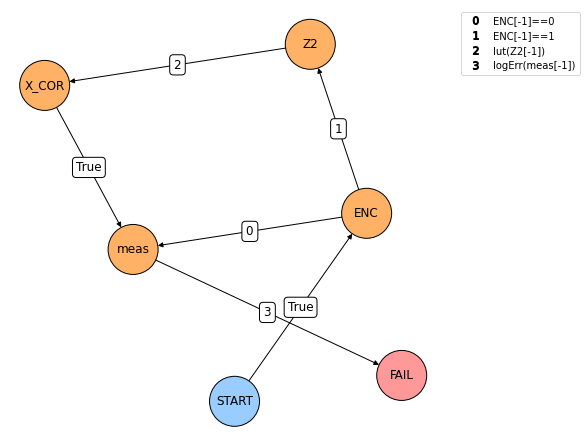

In [ ]:
steane0.draw(figsize=(6,6), edge_legend=True)

## Flag stabilizer protocol
* ...

In [ ]:
# export

def gen_flagstab():
    k1 = 0b0001111
    k2 = 0b1010101
    k3 = 0b0110011
    k12 = k1 ^ k2
    k23 = k2 ^ k3
    k13 = k1 ^ k3
    k123 = k12 ^ k3
    stabilizerGenerators = [k1, k2, k3]
    stabilizerSet = [0, k1, k2, k3, k12, k23, k13, k123]

    def hamming2(x, y):
        count, z = 0, x ^ y
        while z:
            count += 1
            z &= z - 1
        return count

    def logErr(out):
        if min([hamming2(out, i) for i in stabilizerSet]) > 1:
            return True
        else:
            return False

    def flagged(m):
        v = 0b01 in m or 0b11 in m if m is not None else False
        #print('flag', [format(i, '02b') for i in m], ':', v)
        return v

    def flut(m, f1, f2, f3):
        formatter = lambda i,m: str(format(m, '06b')[i])

        sx = ''.join([formatter(i,m) for i in range(3)])
        sz = ''.join([formatter(i,m) for i in range(3,6)])

        if (sz == '011' and flagged(f1)) or (sz == '011' and flagged(f2)) or (sz == '011' and flagged(f3)):
            corrs = {'011': {4, 5}, '101': {2, 4}, '110': {2, 5}} #{'010': {5, 6}, '001': {4, 6}}
            return Circuit([{'X': corrs[sz]}], noisy=False)
        else: 
            return Circuit(noisy=False)

    def rep_check(m):
        # no flag triggered, run second round regardless of syndrome
        v = (m[-1] == 0b00 or m[-1] == 0b10) and len(m) == 1
        #print('rep', [format(i, '02b') for i in m], ':', v)
        return v

    def nft_check(m):
        # flag triggered in first or second round OR no flag triggered, syndromes disagree in second round
        v = (len(m) == 1 and (m[-1] == 0b01 or m[-1] == 0b11)) or (len(m) == 2 and ((m[-1] == 0b00 and m[-2] == 0b10) or (m[-1] == 0b10 and m[-2] == 0b00) or (m[-1] == 0b01 or m[-1] == 0b11)))
        #print('nft', [format(i, '02b') for i in m], ':', v)
        return v

    def syn_check(m):
        # no flag triggered, syndromes agree in second round
        v = len(m) == 2 and ((m[-1] == 0b00 and m[-2] == 0b00) or (m[-1] == 0b10 and m[-2] == 0b10))
        #print('syn', [format(i, '02b') for i in m], ':', v)
        return v  


    functions = {"logErr": logErr, "flut": flut, "rep_check": rep_check, "nft_check": nft_check, "syn_check": syn_check}

    # Define protocol

    flagstab = Protocol()
    flagstab._check_fns.update(functions)
    flagstab.add_nodes_from(['X1', 'X2', 'X3', 'nonFT', 'meas'], circuits=[fmx_1, fmx_2, fmx_3, nfs, meas7])
    flagstab.add_node('COR', circuit=Circuit(noisy=False))

    flagstab.add_edge('START', 'X1', check='True')

    # no flag triggered, run second round regardless of syndrome
    flagstab.add_edge('X1', 'X1', check='rep_check(X1)')
    flagstab.add_edge('X2', 'X2', check='rep_check(X2)')
    flagstab.add_edge('X3', 'X3', check='rep_check(X3)')

    # flag triggered in first or second round OR no flag triggered, syndromes disagree in second round
    flagstab.add_edge('X1', 'nonFT', check='nft_check(X1)')
    flagstab.add_edge('X2', 'nonFT', check='nft_check(X2)')
    flagstab.add_edge('X3', 'nonFT', check='nft_check(X3)')

    # no flag triggered, syndromes agree in second round
    flagstab.add_edge('X1', 'X2', check='syn_check(X1)')#False if rep_check(X1) or nft_check(X1) else True')
    flagstab.add_edge('X2', 'X3', check='syn_check(X2)')#'False if rep_check(X2) or nft_check(X2) else True')
    flagstab.add_edge('X3', 'meas', check='syn_check(X3)')#'False if rep_check(X3) or nft_check(X3) else True')

    # apply flag correction after nonFT if a flag was triggered
    flagstab.add_edge('nonFT', 'COR', check='flut(nonFT[-1], X1, X2, X3)')

    flagstab.add_edge('COR', 'meas', check='True')

    flagstab.add_edge('meas', 'FAIL', check='logErr(meas[-1])')
    
    flagstab.fault_tolerant = True
    
    return flagstab

flagstab = gen_flagstab()

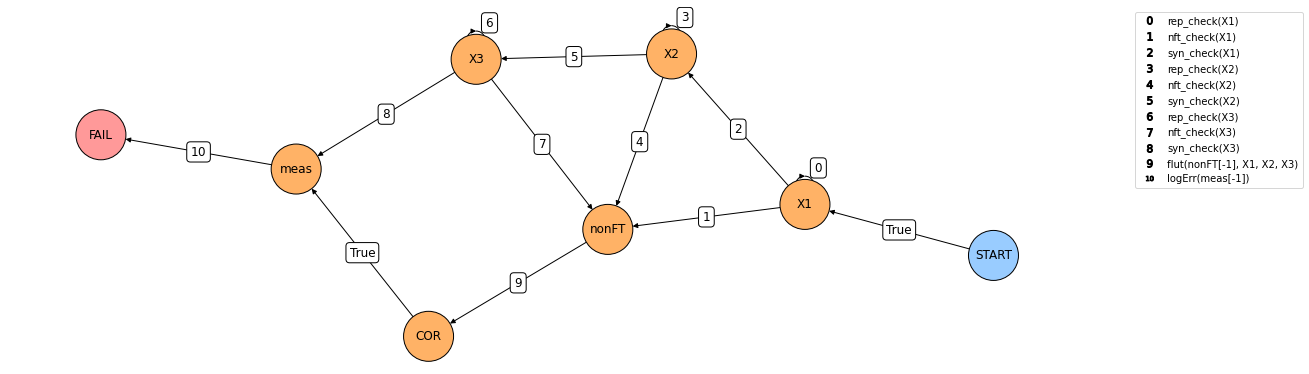

In [ ]:
flagstab.draw(edge_legend=True, figsize=(15,5), self_loop_offset=(0.03,0.08))